<a href="https://colab.research.google.com/github/Hiennoob123/StochasticModel_Miniproject/blob/main/Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


SIMULATION-BASED REINFORCEMENT LEARNING

COMPARING ALL POLICIES

Training RL agent...

TRAINING RL AGENT
Episodes: 10000 | Episode Length: 50h

Episode 500/10000 | Avg Reward: -939.02 | Avg Blocked: 118.5 | Q-table: 5100
Episode 1000/10000 | Avg Reward: 5894.38 | Avg Blocked: 66.2 | Q-table: 7289
Episode 1500/10000 | Avg Reward: 7336.10 | Avg Blocked: 54.0 | Q-table: 8842
Episode 2000/10000 | Avg Reward: 8078.20 | Avg Blocked: 48.7 | Q-table: 10016
Episode 2500/10000 | Avg Reward: 8357.08 | Avg Blocked: 45.4 | Q-table: 10995
Episode 3000/10000 | Avg Reward: 8627.56 | Avg Blocked: 43.8 | Q-table: 11810
Episode 3500/10000 | Avg Reward: 8730.54 | Avg Blocked: 43.0 | Q-table: 12553
Episode 4000/10000 | Avg Reward: 8770.56 | Avg Blocked: 42.2 | Q-table: 13252
Episode 4500/10000 | Avg Reward: 8928.36 | Avg Blocked: 41.0 | Q-table: 13834
Episode 5000/10000 | Avg Reward: 8982.14 | Avg Blocked: 40.7 | Q-table: 14424
Episode 5500/10000 | Avg Reward: 9283.30 | Avg Blocked: 37.9 | Q-table: 14921


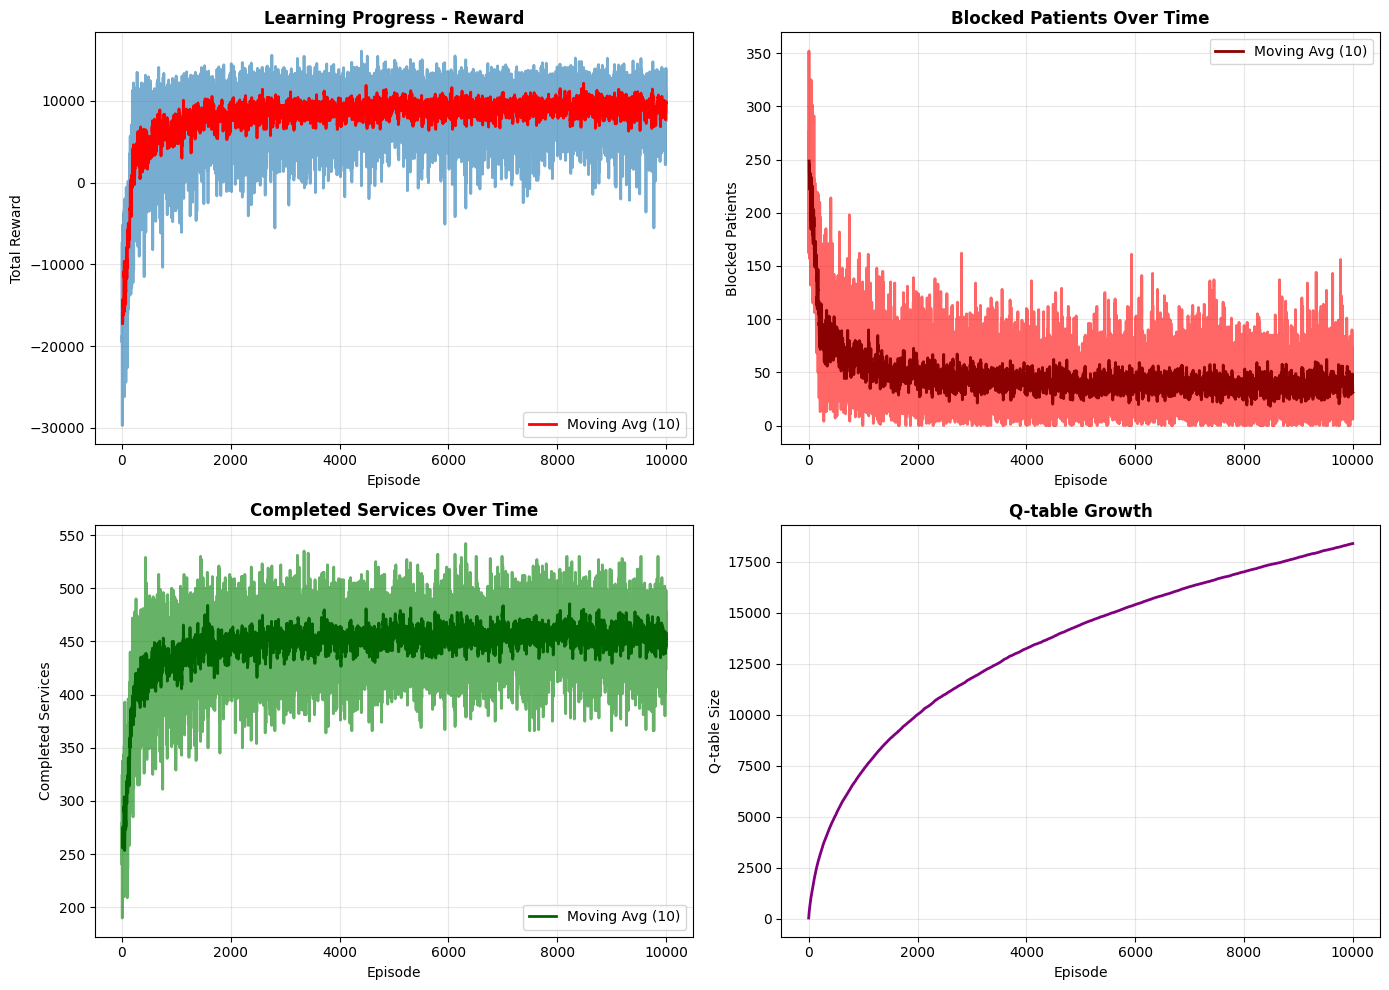


EVALUATING POLICIES

Policy: static       | Reward: -1073270.00 | Completed: 29277 | Blocked: 20562 (41.3%)
Policy: threshold    | Reward: 729490.00 | Completed: 43477 | Blocked: 6270 (12.6%)
Policy: reactive     | Reward: 635820.00 | Completed: 42657 | Blocked: 7187 (14.4%)
Policy: rl           | Reward: 963330.00 | Completed: 46305 | Blocked: 3434 (6.9%)


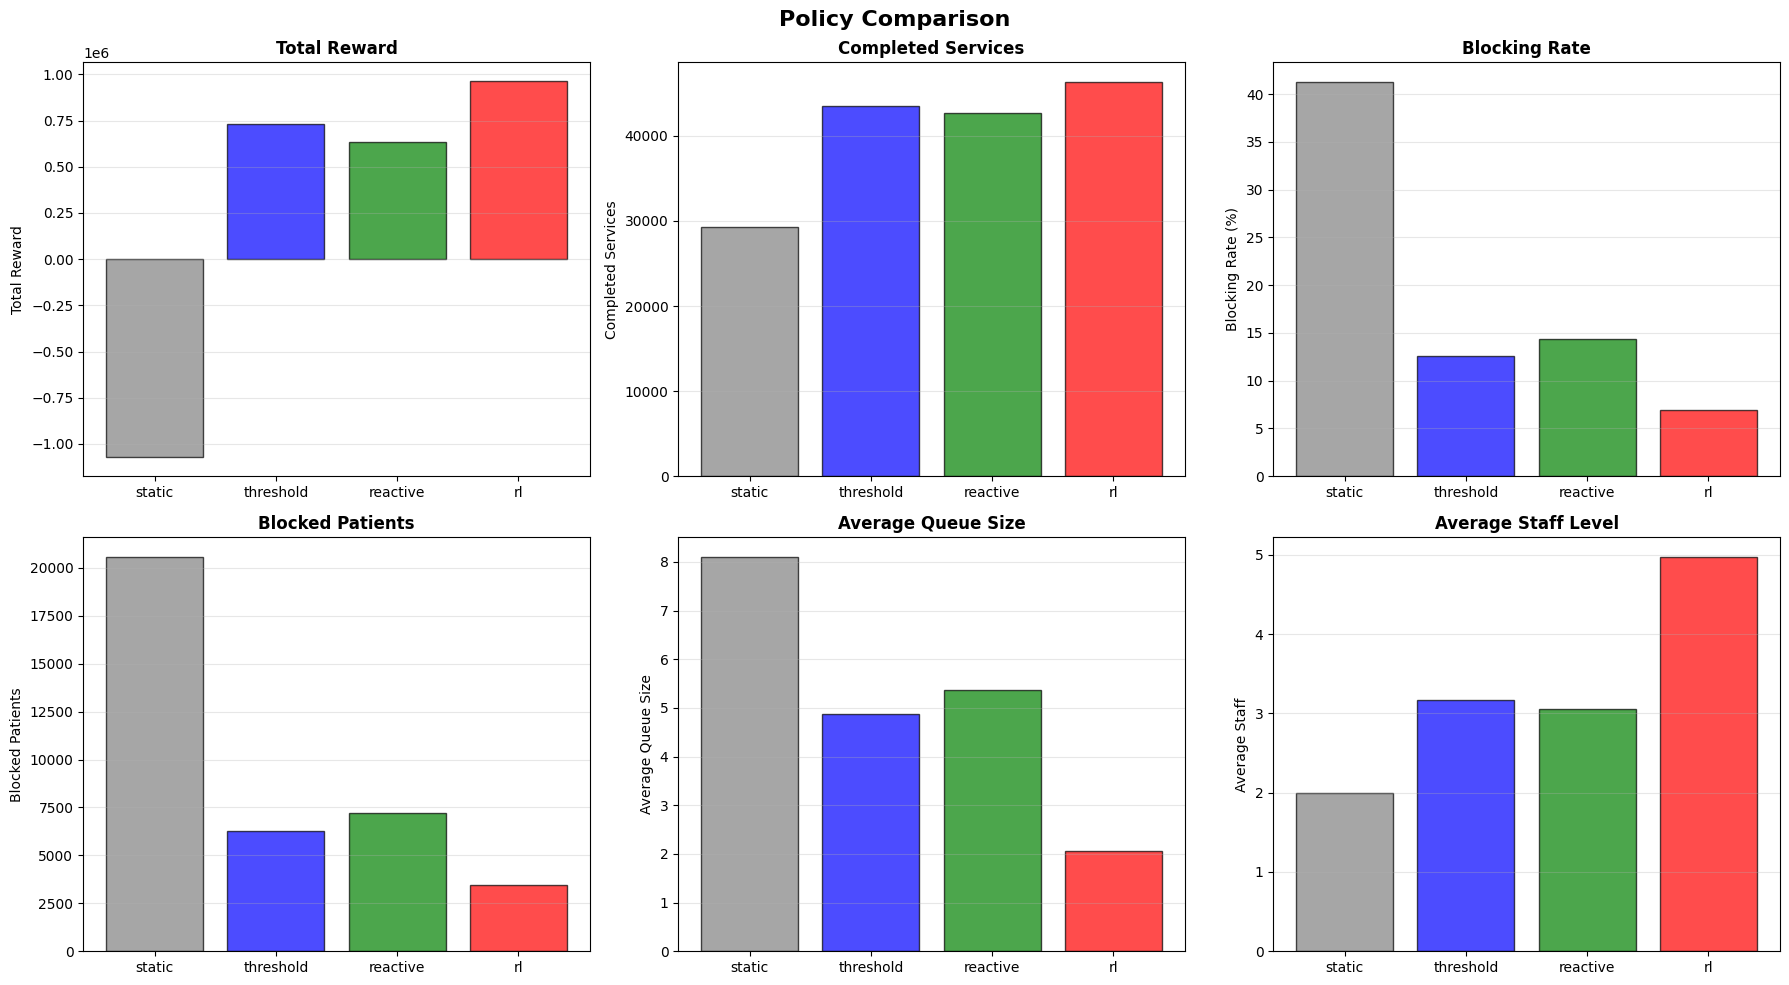

In [34]:
# =============================================================================
# BLOCK 1: Imports and dependencies
# Description:
#   Load all external libraries needed for discrete-event simulation (SimPy),
#   numerical work (NumPy), plotting/animation (Matplotlib), data handling
#   (pandas), and display helpers for notebooks.
# =============================================================================
!pip install simpy
import simpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
from collections import defaultdict
import pandas as pd
from IPython.display import display, HTML


# =============================================================================
# BLOCK 2: Core ED triage system definition
# Description:
#   Define the EDTriageSystem class, which encapsulates the simulation
#   environment, state variables, queues, statistics, and helper utilities.
# =============================================================================
class EDTriageSystem:
    """Emergency Department Triage System with Dynamic Staffing"""

    def __init__(self, env, params):
        self.env = env
        self.params = params

        # System state
        self.current_staff = params['initial_staff']

        # Queue for each triage level - store patient objects
        self.queues = {1: [], 2: [], 3: []}
        self.in_service = {1: [], 2: [], 3: []}  # Store patient objects being served

        # Statistics
        self.stats = {
            'arrivals': 0,
            'arrivals_by_level': {1: 0, 2: 0, 3: 0},
            'blocked': 0,
            'blocked_by_level': {1: 0, 2: 0, 3: 0},
            'completed': {1: 0, 2: 0, 3: 0},
            'total_reward': 0,
            'staff_changes': [],
            'queue_history': [],
            'service_history': [],
            'reward_history': []
        }

        # Patient counter
        self.patient_id = 0

        # Events for logging
        self.events = []

        # All patients for visualization
        self.all_patients = {}  # patient_id -> patient object

    def log_event(self, message):
        """Log an event with timestamp"""
        self.events.append((self.env.now, message))

    def get_total_queue_size(self):
        """Get total patients in queue"""
        return sum(len(q) for q in self.queues.values())

    def get_total_in_service(self):
        """Get total patients in service"""
        return sum(len(s) for s in self.in_service.values())


# =============================================================================
# BLOCK 3: Patient flow processes (arrival, assignment, service)
# Description:
#   SimPy processes that generate patient arrivals, assign them to staff based
#   on triage priority, and simulate service times and completions.
# =============================================================================
    def patient_arrival(self):
        """Generate patient arrivals (Poisson process)"""
        while True:
            # Inter-arrival time (exponential)
            yield self.env.timeout(np.random.exponential(1.0 / self.params['mu']))

            # Assign triage level
            rand = np.random.random()
            if rand < 0.1:
                level = 1  # Critical
            elif rand < 0.4:
                level = 2  # Urgent
            else:
                level = 3  # Non-urgent

            self.patient_id += 1
            self.stats['arrivals'] += 1
            self.stats['arrivals_by_level'][level] += 1

            # Create patient object
            patient = {
                'id': self.patient_id,
                'level': level,
                'arrival_time': self.env.now,
                'service_start': None,
                'completion_time': None,
                'status': 'waiting'  # waiting, in_service, completed, blocked
            }
            self.all_patients[self.patient_id] = patient

            # Check queue capacity
            if self.get_total_queue_size() >= self.params['M']:
                self.stats['blocked'] += 1
                self.stats['blocked_by_level'][level] += 1
                self.stats['total_reward'] -= self.params['cp']
                patient['status'] = 'blocked'
                self.log_event(f"Patient {self.patient_id} (Level {level}) BLOCKED")
            else:
                self.queues[level].append(patient)
                self.log_event(f"Patient {self.patient_id} (Level {level}) arrived")

                # Try to assign to staff immediately
                self.env.process(self.assign_patient_to_staff())

    def assign_patient_to_staff(self):
        """Assign highest priority patient to available staff"""
        # Keep assigning while we have available staff and waiting patients
        while self.get_total_in_service() < self.current_staff:
            assigned = False

            # Find highest priority patient (Level 1 > 2 > 3)
            for level in [1, 2, 3]:
                if len(self.queues[level]) > 0:
                    patient = self.queues[level].pop(0)
                    patient['status'] = 'in_service'
                    patient['service_start'] = self.env.now
                    self.in_service[level].append(patient)

                    self.log_event(f"Patient {patient['id']} (Level {level}) started service")

                    # Start service process
                    self.env.process(self.patient_service(patient))
                    assigned = True
                    break

            # If no patients waiting, stop trying
            if not assigned:
                break

        yield self.env.timeout(0)

    def patient_service(self, patient):
        """Service a patient"""
        level = patient['level']

        # Service time (exponential)
        service_rates = {
            1: self.params['lambda1'],
            2: self.params['lambda2'],
            3: self.params['lambda3']
        }
        service_time = np.random.exponential(1.0 / service_rates[level])

        yield self.env.timeout(service_time)

        # Complete service
        self.in_service[level].remove(patient)
        patient['status'] = 'completed'
        patient['completion_time'] = self.env.now
        self.stats['completed'][level] += 1

        # Add reward
        rewards = {1: self.params['r1'], 2: self.params['r2'], 3: self.params['r3']}
        self.stats['total_reward'] += rewards[level]

        self.log_event(f"Patient {patient['id']} (Level {level}) completed (+{rewards[level]})")

        # Try to assign next patient
        self.env.process(self.assign_patient_to_staff())


# =============================================================================
# BLOCK 4: Costs, logging, and state recording
# Description:
#   Processes for applying hourly maintenance cost, and periodically recording
#   queues, service levels, and cumulative reward for later analysis/plots.
# =============================================================================
    def maintenance_cost(self):
        """Apply maintenance cost every hour"""
        while True:
            yield self.env.timeout(1.0)
            cost = self.params['cm'] * self.current_staff
            self.stats['total_reward'] -= cost
            self.log_event(f"Maintenance cost: -{cost}")

    def record_state(self):
        """Record system state periodically"""
        while True:
            self.stats['queue_history'].append({
                'time': self.env.now,
                'q1': len(self.queues[1]),
                'q2': len(self.queues[2]),
                'q3': len(self.queues[3]),
                'total_queue': self.get_total_queue_size()
            })

            self.stats['service_history'].append({
                'time': self.env.now,
                'b1': len(self.in_service[1]),
                'b2': len(self.in_service[2]),
                'b3': len(self.in_service[3]),
                'total_service': self.get_total_in_service(),
                'staff': self.current_staff
            })

            self.stats['reward_history'].append({
                'time': self.env.now,
                'reward': self.stats['total_reward']
            })

            yield self.env.timeout(0.1)


# =============================================================================
# BLOCK 5: Dynamic staffing control and MDP interface
# Description:
#   Functions to change staff levels, define the MDP state/action space, and
#   implement different staffing policies (static, threshold, reactive, RL).
# =============================================================================
    def change_staff(self, delta):
        """Change staff level"""
        new_staff = max(0, min(self.params['Smax'], self.current_staff + delta))

        if new_staff > self.current_staff:
            # Add staff
            increase = new_staff - self.current_staff
            old_staff = self.current_staff
            self.current_staff = new_staff

            # Apply activation cost per new staff
            self.stats['total_reward'] -= self.params['ca'] * increase
            self.log_event(f"Activated {increase} new staff (-{self.params['ca'] * increase} cost): {old_staff} → {new_staff}")

            # Try to assign waiting patients to newly available staff
            for _ in range(increase):
                self.env.process(self.assign_patient_to_staff())

        elif new_staff < self.current_staff:
            # Decrease staff
            # NOTE: In real system, this would only take effect when staff finish service
            # For now, we immediately reduce capacity (staff can finish current patients)
            decrease = self.current_staff - new_staff
            old_staff = self.current_staff
            self.current_staff = new_staff
            self.log_event(f"Decreased staff by {decrease}: {old_staff} → {new_staff}")

        self.stats['staff_changes'].append({
            'time': self.env.now,
            'staff': self.current_staff,
            'delta': delta
        })

        # Verify constraint: total in service should not exceed staff
        total_in_service = self.get_total_in_service()
        if total_in_service > self.current_staff:
            self.log_event(f"WARNING: {total_in_service} patients in service but only {self.current_staff} staff!")

    def get_state(self):
        """Get current MDP state: (Q1, Q2, Q3, B1, B2, B3, S)"""
        return (
            len(self.queues[1]),
            len(self.queues[2]),
            len(self.queues[3]),
            len(self.in_service[1]),
            len(self.in_service[2]),
            len(self.in_service[3]),
            self.current_staff
        )

    def get_valid_actions(self):
        """Get valid actions: can decrease by any amount or increase by 1"""
        actions = [0]  # Always can do nothing

        # Can increase by 1 if not at max
        if self.current_staff < self.params['Smax']:
            actions.append(1)

        # Can decrease by any amount from -1 to -S_t
        for decrease in range(1, self.current_staff + 1):
            actions.append(-decrease)

        return actions

    def staffing_policy(self, policy_type='static', rl_agent=None):
        """Apply staffing policy"""
        while True:
            yield self.env.timeout(1.0)  # Decision every hour

            if policy_type == 'static':
                pass

            elif policy_type == 'threshold':
                total_queue = self.get_total_queue_size()

                if total_queue > self.params['M'] * 0.7 and self.current_staff < self.params['Smax']:
                    self.change_staff(1)
                elif total_queue < self.params['M'] * 0.3 and self.current_staff > 1:
                    self.change_staff(-1)

            elif policy_type == 'reactive':
                critical_queue = len(self.queues[1])
                total_queue = self.get_total_queue_size()

                if critical_queue > 2 or total_queue > self.params['M'] * 0.8:
                    if self.current_staff < self.params['Smax']:
                        self.change_staff(1)
                elif total_queue < 5 and critical_queue == 0:
                    if self.current_staff > 2:
                        self.change_staff(-1)

            elif policy_type == 'rl' and rl_agent is not None:
                # Get current state
                state = self.get_state()
                valid_actions = self.get_valid_actions()

                # Get action from RL agent
                action = rl_agent.select_action(state, valid_actions)

                # Apply action
                if action != 0:
                    self.change_staff(action)


# =============================================================================
# BLOCK 6: Live visual simulation (animation)
# Description:
#   Function to run the ED triage system in real time and display an animated
#   visualization of queues, treatment area, and key statistics using Matplotlib.
# =============================================================================
def live_visual_simulation(params, sim_time=50, policy='reactive', rl_agent=None):
    """
    Live visual simulation with animated patients as dots
    Shows patients queueing and being served in real-time
    """
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML

    env = simpy.Environment()
    system = EDTriageSystem(env, params)

    # Start processes
    env.process(system.patient_arrival())
    env.process(system.maintenance_cost())
    env.process(system.record_state())
    env.process(system.staffing_policy(policy, rl_agent))

    # Setup figure
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # Main visualization area - ED Layout
    ax_main = fig.add_subplot(gs[:2, :2])

    # Statistics plots
    ax_queue = fig.add_subplot(gs[0, 2])
    ax_reward = fig.add_subplot(gs[1, 2])
    ax_stats = fig.add_subplot(gs[2, :])

    # Colors for triage levels
    colors = {1: 'red', 2: 'orange', 3: 'gold'}

    def draw_ed_layout(ax):
        """Draw the ED layout background"""
        ax.clear()
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.set_aspect('equal')
        ax.axis('off')

        # Title
        ax.text(5, 9.5, 'Emergency Department - Live Simulation',
                ha='center', fontsize=14, fontweight='bold')
        ax.text(5, 9, f'Time: {env.now:.1f}h | Policy: {policy} | Staff: {system.current_staff}/{params["Smax"]}',
                ha='center', fontsize=10)

        # Entrance
        entrance = mpatches.Rectangle((0, 7), 1, 2, linewidth=2,
                                     edgecolor='black', facecolor='lightblue', alpha=0.3)
        ax.add_patch(entrance)
        ax.text(0.5, 8, 'ENTRANCE', ha='center', va='center', fontsize=8, fontweight='bold')

        # Queue areas
        queue_y_positions = {1: 7.5, 2: 5.5, 3: 3.5}
        queue_labels = {1: 'CRITICAL', 2: 'URGENT', 3: 'NON-URGENT'}

        for level in [1, 2, 3]:
            y_pos = queue_y_positions[level]
            queue_box = mpatches.Rectangle((1.5, y_pos-0.4), 4, 0.8, linewidth=2,
                                          edgecolor=colors[level], facecolor=colors[level], alpha=0.1)
            ax.add_patch(queue_box)
            ax.text(1.2, y_pos, f'L{level}:', ha='right', va='center',
                   fontsize=9, fontweight='bold', color=colors[level])
            ax.text(3.5, y_pos+0.5, queue_labels[level], ha='center', va='bottom',
                   fontsize=8, color=colors[level], fontweight='bold')

        # Treatment area
        treatment = mpatches.Rectangle((6.5, 2.5), 3, 5.5, linewidth=2,
                                      edgecolor='green', facecolor='lightgreen', alpha=0.2)
        ax.add_patch(treatment)
        ax.text(8, 7.5, 'TREATMENT AREA', ha='center', fontsize=10, fontweight='bold')

        # Staff positions (beds)
        staff_positions = []
        for i in range(params['Smax']):
            row = i // 3
            col = i % 3
            x = 7 + col * 0.8
            y = 6.5 - row * 0.8
            staff_positions.append((x, y))

            # Draw bed
            if i < system.current_staff:
                bed = mpatches.Circle((x, y), 0.15, color='green', alpha=0.3)
            else:
                bed = mpatches.Circle((x, y), 0.15, color='gray', alpha=0.2)
            ax.add_patch(bed)

        return staff_positions, queue_y_positions

    def draw_patients(ax, staff_positions, queue_y_positions):
        """Draw patients as colored dots"""
        # Draw queue patients
        for level in [1, 2, 3]:
            y_pos = queue_y_positions[level]
            queue = system.queues[level]

            for idx, patient in enumerate(queue):
                x = 2 + (idx % 10) * 0.35
                y = y_pos + (idx // 10) * 0.15

                circle = mpatches.Circle((x, y), 0.12, color=colors[level],
                                        edgecolor='black', linewidth=1, zorder=10)
                ax.add_patch(circle)

                # Patient ID
                ax.text(x, y, str(patient['id']), ha='center', va='center',
                       fontsize=6, color='white', fontweight='bold', zorder=11)

        # Draw patients in service
        service_idx = 0
        for level in [1, 2, 3]:
            for patient in system.in_service[level]:
                if service_idx < len(staff_positions):
                    x, y = staff_positions[service_idx]

                    circle = mpatches.Circle((x, y), 0.15, color=colors[level],
                                           edgecolor='darkgreen', linewidth=2, zorder=10)
                    ax.add_patch(circle)

                    ax.text(x, y, str(patient['id']), ha='center', va='center',
                           fontsize=7, color='white', fontweight='bold', zorder=11)

                    service_idx += 1

        # Legend
        legend_elements = [
            mpatches.Patch(color='red', label='Level 1 (Critical)'),
            mpatches.Patch(color='orange', label='Level 2 (Urgent)'),
            mpatches.Patch(color='gold', label='Level 3 (Non-urgent)')
        ]
        ax.legend(handles=legend_elements, loc='lower left', fontsize=8)

    def update_statistics_plots():
        """Update the statistics plots"""
        if len(system.stats['queue_history']) < 2:
            return

        df_queue = pd.DataFrame(system.stats['queue_history'])
        df_reward = pd.DataFrame(system.stats['reward_history'])

        # Queue plot
        ax_queue.clear()
        ax_queue.plot(df_queue['time'], df_queue['q1'], 'r-', linewidth=2, label='L1')
        ax_queue.plot(df_queue['time'], df_queue['q2'], color='orange', linewidth=2, label='L2')
        ax_queue.plot(df_queue['time'], df_queue['q3'], color='gold', linewidth=2, label='L3')
        ax_queue.axhline(y=params['M'], color='red', linestyle=':', label='Capacity')
        ax_queue.set_xlabel('Time (h)', fontsize=8)
        ax_queue.set_ylabel('Queue Size', fontsize=8)
        ax_queue.set_title('Queue Over Time', fontsize=9, fontweight='bold')
        ax_queue.legend(fontsize=7)
        ax_queue.grid(True, alpha=0.3)
        ax_queue.tick_params(labelsize=7)

        # Reward plot
        ax_reward.clear()
        ax_reward.plot(df_reward['time'], df_reward['reward'], 'purple', linewidth=2)
        ax_reward.set_xlabel('Time (h)', fontsize=8)
        ax_reward.set_ylabel('Reward', fontsize=8)
        ax_reward.set_title('Cumulative Reward', fontsize=9, fontweight='bold')
        ax_reward.grid(True, alpha=0.3)
        ax_reward.tick_params(labelsize=7)

        # Statistics bar
        ax_stats.clear()
        stats_labels = ['Arrivals', 'In Queue', 'In Service', 'Completed', 'Blocked']
        stats_values = [
            system.stats['arrivals'],
            system.get_total_queue_size(),
            system.get_total_in_service(),
            sum(system.stats['completed'].values()),
            system.stats['blocked']
        ]
        stats_colors = ['blue', 'orange', 'green', 'lightgreen', 'red']

        bars = ax_stats.bar(stats_labels, stats_values, color=stats_colors, alpha=0.7, edgecolor='black')
        ax_stats.set_ylabel('Count', fontsize=9)
        ax_stats.set_title(f'Statistics | Reward: {system.stats["total_reward"]:.2f}',
                          fontsize=10, fontweight='bold')
        ax_stats.grid(True, alpha=0.3, axis='y')
        ax_stats.tick_params(labelsize=8)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax_stats.text(bar.get_x() + bar.get_width()/2., height,
                         f'{int(height)}', ha='center', va='bottom', fontsize=8, fontweight='bold')

    def animate(frame):
        """Animation function"""
        # Run simulation for a small time step
        env.run(until=env.now + 0.2)

        # Redraw everything
        staff_positions, queue_y_positions = draw_ed_layout(ax_main)
        draw_patients(ax_main, staff_positions, queue_y_positions)
        update_statistics_plots()

        return ax_main, ax_queue, ax_reward, ax_stats

    # Initial draw
    staff_positions, queue_y_positions = draw_ed_layout(ax_main)

    # Create animation
    frames = int(sim_time / 0.2)
    anim = FuncAnimation(fig, animate, frames=frames, interval=200, blit=False, repeat=False)

    plt.tight_layout()

    return anim, system


# =============================================================================
# BLOCK 7: Q-learning agent
# Description:
#   Define a tabular Q-Learning agent that interacts with the MDP defined by
#   EDTriageSystem, maintaining a Q-table and providing action-selection
#   and update rules.
# =============================================================================
class QLearningAgent:
    """
    Q-Learning agent for dynamic staffing control
    State: (Q1, Q2, Q3, B1, B2, B3, S)
    Action: {-S, ..., -1, 0, +1}
    """

    def __init__(self, params, learning_rate=0.1, discount_factor=0.95, epsilon=1):
        self.params = params
        self.alpha = learning_rate  # Learning rate
        self.gamma = discount_factor  # Discount factor
        self.epsilon = epsilon  # Exploration rate

        # Q-table: Q(state, action) -> value
        self.q_table = {}

        # For tracking
        self.episode_rewards = []
        self.episode_states = []
        self.episode_actions = []
        self.episodes = 0

    # Decay epsilon function
    def decay_epsilon(self, episode):
        self.epsilon = max(0.1, 1.0 - 0.000099 * episode)

    def get_q_value(self, state, action):
        """Get Q-value for state-action pair"""
        return self.q_table.get((state, action), 0.0)

    def select_action(self, state, valid_actions, training=True):
        """Select action using epsilon-greedy policy"""
        # Update epsidlon
        self.episodes += 1
        self.decay_epsilon(self.episodes)

        if training and np.random.random() < self.epsilon:
            # Improve exploration by increase the chance of choosing +1.
            # if 1 in valid_actions:
            #     current_len = len(valid_actions)
            #     for i in range(current_len // 2):
            #         valid_actions.append(1)

            # Explore: random action
            return np.random.choice(valid_actions)
        else:
            # Exploit: best action
            q_values = [self.get_q_value(state, a) for a in valid_actions]
            max_q = max(q_values)

            # Handle ties randomly
            best_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q]
            return np.random.choice(best_actions)

    def update_q_value(self, state, action, reward, next_state, next_valid_actions):
        """Update Q-value using Q-learning update rule"""
        current_q = self.get_q_value(state, action)

        # Get max Q-value for next state
        if next_valid_actions:
            next_q_values = [self.get_q_value(next_state, a) for a in next_valid_actions]
            max_next_q = max(next_q_values)
        else:
            max_next_q = 0.0

        # Q-learning update
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[(state, action)] = new_q

    def get_policy(self):
        """Extract policy from Q-table"""
        policy = {}

        for (state, action), q_value in self.q_table.items():
            if state not in policy or q_value > policy[state][1]:
                policy[state] = (action, q_value)

        return policy

    def save_policy(self, filename):
        """Save Q-table to file"""
        import pickle
        with open(filename, 'wb') as f:
            pickle.dump(self.q_table, f)

    def load_policy(self, filename):
        """Load Q-table from file"""
        import pickle
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)


# =============================================================================
# BLOCK 8: Simulation-based RL trainer
# Description:
#   Class that uses the simulation (EDTriageSystem + SimPy) to generate
#   episodes, let the RL agent interact, update Q-values, and track training
#   metrics and progress.
# =============================================================================
class SimulationBasedRLTrainer:
    """Train RL agent using simulation-based approach"""

    def __init__(self, params, agent):
        self.params = params
        self.agent = agent
        self.training_history = []

    def run_episode(self, episode_length=50, verbose=False):
        """Run one training episode"""
        env = simpy.Environment()
        system = EDTriageSystem(env, self.params)

        # Start basic processes (no staffing policy yet)
        env.process(system.patient_arrival())
        env.process(system.maintenance_cost())
        env.process(system.record_state())

        # Manual RL control process
        env.process(self.rl_control_process(env, system, episode_length))

        # Run simulation
        env.run(until=episode_length)

        total_reward = system.stats['total_reward']

        if verbose:
            print(f"Episode completed: Reward = {total_reward:.2f}, "
                  f"Arrivals = {system.stats['arrivals']}, "
                  f"Blocked = {system.stats['blocked']}, "
                  f"Completed = {sum(system.stats['completed'].values())}")

        return total_reward, system

    def rl_control_process(self, env, system, episode_length):
        """Process for RL agent to make decisions"""
        prev_state = None
        prev_action = None
        prev_reward = 0

        while env.now < episode_length:
            yield env.timeout(1.0)  # Decision every hour

            # Get current state
            current_state = system.get_state()
            valid_actions = system.get_valid_actions()

            # Calculate reward from last step
            current_reward = system.stats['total_reward']
            step_reward = current_reward - prev_reward

            # Update Q-value if we have a previous transition
            if prev_state is not None:
                self.agent.update_q_value(
                    prev_state, prev_action, step_reward,
                    current_state, valid_actions
                )

            # Select and execute action
            action = self.agent.select_action(current_state, valid_actions, training=True)

            if action != 0:
                system.change_staff(action)

            # Store for next update
            prev_state = current_state
            prev_action = action
            prev_reward = current_reward

    def train(self, num_episodes=100, episode_length=50, verbose_interval=10):
        """Train the agent over multiple episodes"""
        print(f"\n{'='*70}")
        print(f"TRAINING RL AGENT")
        print(f"Episodes: {num_episodes} | Episode Length: {episode_length}h")
        print(f"{'='*70}\n")

        episode_rewards = []

        for episode in range(num_episodes):
            reward, system = self.run_episode(episode_length, verbose=False)
            episode_rewards.append(reward)

            self.training_history.append({
                'episode': episode,
                'reward': reward,
                'arrivals': system.stats['arrivals'],
                'blocked': system.stats['blocked'],
                'completed': sum(system.stats['completed'].values()),
                'q_table_size': len(self.agent.q_table)
            })

            if (episode + 1) % verbose_interval == 0:
                avg_reward = np.mean(episode_rewards[-verbose_interval:])
                avg_blocked = np.mean([h['blocked'] for h in self.training_history[-verbose_interval:]])
                print(f"Episode {episode+1}/{num_episodes} | "
                      f"Avg Reward: {avg_reward:.2f} | "
                      f"Avg Blocked: {avg_blocked:.1f} | "
                      f"Q-table: {len(self.agent.q_table)}")

        print(f"\n{'='*70}")
        print(f"TRAINING COMPLETE")
        print(f"Final Q-table size: {len(self.agent.q_table)}")
        print(f"Average reward (last 10 episodes): {np.mean(episode_rewards[-10:]):.2f}")
        print(f"{'='*70}\n")

        return episode_rewards

    def plot_training_progress(self):
        """Plot training progress"""
        df = pd.DataFrame(self.training_history)

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # Reward over episodes
        axes[0, 0].plot(df['episode'], df['reward'], linewidth=2, alpha=0.6)
        # Moving average
        window = min(10, len(df) // 10)
        if window > 0:
            moving_avg = df['reward'].rolling(window=window).mean()
            axes[0, 0].plot(df['episode'], moving_avg, 'r-', linewidth=2, label=f'Moving Avg ({window})')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Total Reward')
        axes[0, 0].set_title('Learning Progress - Reward', fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Blocked patients
        axes[0, 1].plot(df['episode'], df['blocked'], 'r-', linewidth=2, alpha=0.6)
        if window > 0:
            moving_avg = df['blocked'].rolling(window=window).mean()
            axes[0, 1].plot(df['episode'], moving_avg, 'darkred', linewidth=2, label=f'Moving Avg ({window})')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Blocked Patients')
        axes[0, 1].set_title('Blocked Patients Over Time', fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Completed services
        axes[1, 0].plot(df['episode'], df['completed'], 'g-', linewidth=2, alpha=0.6)
        if window > 0:
            moving_avg = df['completed'].rolling(window=window).mean()
            axes[1, 0].plot(df['episode'], moving_avg, 'darkgreen', linewidth=2, label=f'Moving Avg ({window})')
        axes[1, 0].set_xlabel('Episode')
        axes[1, 0].set_ylabel('Completed Services')
        axes[1, 0].set_title('Completed Services Over Time', fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Q-table growth
        axes[1, 1].plot(df['episode'], df['q_table_size'], 'purple', linewidth=2)
        axes[1, 1].set_xlabel('Episode')
        axes[1, 1].set_ylabel('Q-table Size')
        axes[1, 1].set_title('Q-table Growth', fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


# =============================================================================
# BLOCK 9: Policy comparison wrapper
# Description:
#   High-level function to train the RL agent, evaluate all policies (static,
#   threshold, reactive, RL), print summary metrics, and visualize comparisons.
# =============================================================================
def compare_all_policies(params, sim_time=5000):
    """Compare all policies including RL"""
    print(f"\n{'='*70}")
    print("COMPARING ALL POLICIES")
    print(f"{'='*70}\n")

    # Train RL agent first
    print("Training RL agent...")
    agent = QLearningAgent(params, learning_rate=0.1, discount_factor=0.95, epsilon=0.2)
    trainer = SimulationBasedRLTrainer(params, agent)
    episode_rewards = trainer.train(num_episodes=10000, episode_length=50, verbose_interval=500)
    trainer.plot_training_progress()

    # Set to exploitation mode
    agent.epsilon = 0.0  # No exploration during evaluation

    policies = {
        'static': None,
        'threshold': None,
        'reactive': None,
        'rl': agent
    }

    results = {}

    print(f"\n{'='*70}")
    print("EVALUATING POLICIES")
    print(f"{'='*70}\n")

    for policy_name, rl_agent in policies.items():
        # Run simulation
        env = simpy.Environment()
        system = EDTriageSystem(env, params)

        env.process(system.patient_arrival())
        env.process(system.maintenance_cost())
        env.process(system.record_state())
        env.process(system.staffing_policy(policy_name if policy_name != 'rl' else 'rl', rl_agent))

        env.run(until=sim_time)

        results[policy_name] = {
            'total_reward': system.stats['total_reward'],
            'completed': sum(system.stats['completed'].values()),
            'blocked': system.stats['blocked'],
            'blocking_rate': system.stats['blocked']/max(1, system.stats['arrivals'])*100,
            'avg_queue': np.mean([h['total_queue'] for h in system.stats['queue_history']]) if system.stats['queue_history'] else 0,
            'avg_staff': np.mean([h['staff'] for h in system.stats['service_history']]) if system.stats['service_history'] else params['initial_staff']
        }

        print(f"Policy: {policy_name:12s} | Reward: {results[policy_name]['total_reward']:8.2f} | "
              f"Completed: {results[policy_name]['completed']:4d} | "
              f"Blocked: {results[policy_name]['blocked']:3d} ({results[policy_name]['blocking_rate']:.1f}%)")

    # Plot comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Policy Comparison', fontsize=16, fontweight='bold')

    policy_names = list(results.keys())
    colors_map = {'static': 'gray', 'threshold': 'blue', 'reactive': 'green', 'rl': 'red'}
    colors = [colors_map[p] for p in policy_names]

    # Total reward
    axes[0, 0].bar(policy_names, [results[p]['total_reward'] for p in policy_names], color=colors, alpha=0.7, edgecolor='black')
    axes[0, 0].set_ylabel('Total Reward')
    axes[0, 0].set_title('Total Reward', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # Completed services
    axes[0, 1].bar(policy_names, [results[p]['completed'] for p in policy_names], color=colors, alpha=0.7, edgecolor='black')
    axes[0, 1].set_ylabel('Completed Services')
    axes[0, 1].set_title('Completed Services', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # Blocking rate
    axes[0, 2].bar(policy_names, [results[p]['blocking_rate'] for p in policy_names], color=colors, alpha=0.7, edgecolor='black')
    axes[0, 2].set_ylabel('Blocking Rate (%)')
    axes[0, 2].set_title('Blocking Rate', fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3, axis='y')

    # Blocked patients
    axes[1, 0].bar(policy_names, [results[p]['blocked'] for p in policy_names], color=colors, alpha=0.7, edgecolor='black')
    axes[1, 0].set_ylabel('Blocked Patients')
    axes[1, 0].set_title('Blocked Patients', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Average queue size
    axes[1, 1].bar(policy_names, [results[p]['avg_queue'] for p in policy_names], color=colors, alpha=0.7, edgecolor='black')
    axes[1, 1].set_ylabel('Average Queue Size')
    axes[1, 1].set_title('Average Queue Size', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    # Average staff
    axes[1, 2].bar(policy_names, [results[p]['avg_staff'] for p in policy_names], color=colors, alpha=0.7, edgecolor='black')
    axes[1, 2].set_ylabel('Average Staff')
    axes[1, 2].set_title('Average Staff Level', fontweight='bold')
    axes[1, 2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    return results, agent


# =============================================================================
# BLOCK 10: Main entry point and default parameters
# Description:
#   Script entry for running the full experiment: define base parameters,
#   train and compare all policies, and (optionally) run a live visualization.
# =============================================================================
if __name__ == "__main__":
    # Parameters
    params = {
        'mu': 10.0,           # Arrival rate per hour
        'lambda1': 2,       # Service rate for critical
        'lambda2': 4,       # Service rate for urgent
        'lambda3': 6,       # Service rate for non-urgent
        'M': 10,              # Queue capacity
        'Smax': 10,           # Max staff
        'initial_staff': 2,   # Initial staff
        'r1': 100,            # Reward for critical
        'r2': 50,             # Reward for urgent
        'r3': 20,             # Reward for non-urgent
        'cm': 10,             # Maintenance cost per staff per hour
        'ca': 50,             # Activation cost per staff
        'cp': 100            # Blocking penalty per patient
    }

    # ========================================================================
    # OPTION 1: Train and compare all policies
    # ========================================================================
    print("\n" + "="*70)
    print("SIMULATION-BASED REINFORCEMENT LEARNING")
    print("="*70)
    results, trained_agent = compare_all_policies(params, sim_time=5000)

    # ========================================================================
    # OPTION 2: Run live visual simulation with trained RL agent
    # (commented out by default)
    # ========================================================================
    # print("\n" + "="*70)
    # print("LIVE VISUAL SIMULATION WITH RL POLICY")
    # print("="*70)
    # print("\nRunning visual simulation with trained RL agent...")
    # print("- Patients shown as colored dots")
    # print("- RL agent makes staffing decisions every hour")
    # print("="*70)

    # For Jupyter notebook:
    # %matplotlib notebook  # or %matplotlib widget
    # anim, system = live_visual_simulation(params, sim_time=50, policy='rl', rl_agent=trained_agent)

    # plt.show()

    # print("\n" + "="*70)
    # print("SIMULATION COMPLETE")
    # print("="*70)
    # print(f"Final Statistics with RL Policy:")
    # print(f"  Total Arrivals: {system.stats['arrivals']}")
    # if system.stats['arrivals'] > 0:
    #     print(f"  Total Blocked: {system.stats['blocked']} ({system.stats['blocked']/system.stats['arrivals']*100:.2f}%)")
    # else:
    #     print(f"  Total Blocked: {system.stats['blocked']} (N/A - no arrivals)")
    # print(f"  Total Completed: {sum(system.stats['completed'].values())}")
    # print(f"  Final Reward: {system.stats['total_reward']:.2f}")
    # print(f"  Q-table size: {len(trained_agent.q_table)} states")
    # print("="*70)
